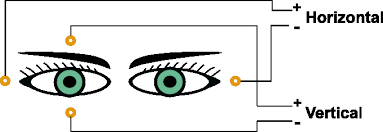

# **Installation**

In [112]:
# !unzip /content/eog_classes.zip

In [113]:
!pip install statsmodels

In [114]:
import statsmodels
print(statsmodels.__version__)


0.14.4


#  **Importation**

In [115]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pywt as wt
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg
from scipy.signal import butter, filtfilt, decimate
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, label_binarize # Added label_binarize import
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from itertools import cycle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import pickle



# **Helper Functions**

In [116]:

# handle files that not including in [1-20/h-v]
def is_valid_file(filename):
    match = re.match(r'^([a-zA-Z]+)([1-9]|1[0-9]|20)[hv]?\.txt$', filename, re.IGNORECASE)
    return bool(match)

In [117]:

# take class name & read all files for this class & return a dict of files
def load_class_data_(class_name):
    data_dir = os.path.join("EOG_Dataset", class_name)
    data = {"horizontal": [], "vertical": []}

    for filename in os.listdir(data_dir):
        filepath = os.path.join(data_dir, filename)
        signal = np.loadtxt(filepath)

        if "h.txt" in filename.lower():
            data["horizontal"].append(signal)
        elif "v.txt" in filename.lower():
            data["vertical"].append(signal)

    return data

In [254]:
# based on the new data file [eog_classes]
def load_class_data():
    class_labels = {
        "Blink": 0,
        "Down": 1,
        "Left": 2,
        "Right": 3,
        "Up": 4
    }
    horizontal = []
    vertical = []

    for class_name in class_labels.keys():
        data_dir = os.path.join("eog_classes", class_name)

        if not os.path.exists(data_dir):
            continue

        # Process each file in the directory
        for filename in os.listdir(data_dir):
            filepath = os.path.join(data_dir, filename)

            signal = np.loadtxt(filepath)

            # Add class label as the last element
            labeled_signal = np.append(signal, class_labels[class_name])

            if "h.txt" in filename.lower():
                horizontal.append(labeled_signal)
            elif "v.txt" in filename.lower():
                vertical.append(labeled_signal)

    horizontal = np.array(horizontal)
    vertical = np.array(vertical)

    h_train, h_test = train_test_split(horizontal, test_size=0.25)
    v_train, v_test = train_test_split(vertical, test_size=0.25)

    return {
        "horizontal": {
            "train": h_train,
            "test": h_test
        },
        "vertical": {
            "train": v_train,
            "test": v_test
        }
    }



In [119]:
# plot data before preprocessing
def plot_raw_eog(signal, class_name, num_samples=3):
    plt.figure(figsize=(15, 8))
    for i in range(min(num_samples, len(signal))):
        plt.subplot(num_samples, 1, i+1)
        plt.plot(signal[i], label=f'Sample {i+1}')
        plt.title(f'Class "{class_name}" - Raw EOG (Sample {i+1})')
        plt.xlabel('Time (samples)')
        plt.ylabel('Amplitude (µV)')
        #plt.grid(True)
        plt.legend()
    plt.tight_layout()
    plt.show()

In [120]:
# at lecture dr. Manal said that from 1 to 20 => [preserve EOG band from 1 to 20-30 HZ]
def butter_bandpass_filter(signal, low_cut=1, high_cut=20, fs=176, order=2):
    nyq = 0.5 * fs # nyq sampling
    low = low_cut / nyq
    high = high_cut / nyq
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, signal)
    return filtered_data


In [121]:

# apply normalization
def norm(signal):
    max_val = np.max(signal)
    min_val = np.min(signal)
    normalized_signal = (signal - min_val) / (max_val - min_val)
    return normalized_signal


In [122]:
# remove DC Component
def remove_dc(signal):
    removed_dc = signal - np.mean(signal)
    return removed_dc


In [123]:
# apply band-pass on dataset
def filter_dataset(data):
    signals, labels = extract_features_labels(data) # labels of classes
    filtered_signals = np.array([butter_bandpass_filter(signal) for signal in signals])
    return np.column_stack((filtered_signals, labels))

In [124]:
def ploting_signal(original_signal, filtered_signal):
    t = np.linspace(0, len(original_signal) / 176, len(original_signal), endpoint=False)

    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(t, original_signal, color='gray')
    plt.title('Original EOG Signal (Before Filtering)')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')

    plt.subplot(2, 1, 2)
    plt.plot(t, filtered_signal, color='blue')
    plt.title('Filtered EOG Signal (1-20 Hz Bandpass)')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

In [125]:
from scipy.signal import decimate

def downsample_filtered_data(filtered_signal, original_fs=250, target_fs=150):
    factor = int(original_fs / target_fs)
    return decimate(filtered_signal, factor, zero_phase=True)


In [126]:

def apply_wavelet(dataset):
    signals, labels = extract_features_labels(dataset)
    features = []

    for signal in signals:
        coeffs = extract_dwt_features(signal)
        features.append(coeffs)

    return np.column_stack((np.array(features), labels))

In [127]:
# extract features & labels
def extract_features_labels(data):
    data = np.array(data)
    signals = data[:, :-1]
    labels = data[:, -1].astype(int)
    return signals, labels

def to_feature_array(dataset_filtered):
  return np.array([
      np.append(process_pipeline(sig), label)
      for sig, label in zip(dataset_filtered[:, :-1], dataset_filtered[:, -1])
  ])


In [144]:

# هنا نقدر نغير براحتنا في ال بريبروسيسنج وبالترتيب اللي يطلع احسن اكيوريسي
# apply on filtered_signal => [downsampling, normalization, DWT, AR]
def process_pipeline(filtered_signal):
    processed_signal = filtered_signal

    # Step 1: Downsample the filtered signal
    processed_signal = downsample_filtered_data(processed_signal)

    # Step 2: Remove DC component
    processed_signal = remove_dc(processed_signal)

    # Step 3: Apply DWT (Discrete Wavelet Transform) and extract features
    dwt_features = extract_dwt_features(processed_signal)

    return dwt_features


In [129]:
def to_feature_array(dataset_filtered, ar_order=250):
  features = []
  for sig, label in zip(dataset_filtered[:, :-1], dataset_filtered[:, -1]):
    _, ar_feats = process_pipeline(sig, ar_order)

  return np.array(ar_feats)


# **Diff Feature Extraction**

## [1] DWT Features

In [130]:

# split signal into approximation (low-frequency) & detail (high-frequency) coefficients at multiple scales
def extract_dwt_features(signal, wavelet='db4', level=2): # signal = amplitude
    coeffs = wt.wavedec(signal, wavelet, level=level)
    # Return approximation and detail coefficients
    return coeffs[0]


## [2] Auto Regression

In [219]:
import numpy as np
from statsmodels.tsa.ar_model import AutoReg

def compute_ar_coefficients(signal, order=5):
    try:
        length = len(signal)
        # print(f"Length of signal: {length}")  # طباعة طول الإشارة

        # تعديل order لو الإشارة قصيرة
        if length <= order:
            order = length - 1
        if order < 1:
            return np.zeros(1)  # لو الإشارة قصيرة جدًا

        model = AutoReg(signal, lags=order)
        results = model.fit()
        coefficients = results.params  # معاملات AR مع ال intercept
        return coefficients
    except Exception as e:
        # print(f"Error computing AR coefficients: {e}")
        return np.zeros(order + 1)


In [220]:

def to_feature_array(dataset_filtered, ar_order=250):
    features = []
    for i in range(len(dataset_filtered)):
        sig = dataset_filtered[i, :-1]   # افتراض ان الأعمدة الاخيرة هي الملصقات (labels)
        label = dataset_filtered[i, -1]


        # Step 1: Downsample the filtered signal
        processed_signal = downsample_filtered_data(sig)

        # Step 2: Remove DC component
        processed_signal = remove_dc(sig)
        ar_feats = compute_ar_coefficients(processed_signal, ar_order)
        # دمج معاملات AR مع التسمية label
        combined_feats = np.concatenate([ar_feats, [label]])
        features.append(combined_feats)
    return np.array(features)


In [133]:
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

def evaluate_ar_lags(signal_2d, max_lag=30):
    # اختيار العمود الأول فقط لتحويل الإشارة 2D إلى 1D
    signal = signal_2d[:, 0]

    best_lag = 1
    best_mse = float('inf')

    train_size = int(len(signal) * 0.8)
    train, test = signal[:train_size], signal[train_size:]

    for lag in range(1, max_lag+1):
        try:
            model = AutoReg(train, lags=lag).fit()
            preds = model.predict(start=len(train), end=len(train)+len(test)-1)
            mse = mean_squared_error(test, preds)
            print(f'Lag: {lag}, MSE: {mse:.4f}')
            if mse < best_mse:
                best_mse = mse
                best_lag = lag
        except Exception as e:
            print(f'Error at lag {lag}: {e}')
            continue

    return best_lag, best_mse




## [3] Hjorth Parameters


In [134]:
# دالة حساب معلمات هجورث (Activity, Mobility, Complexity)
def hjorth_parameters(signal):
    first_deriv = np.diff(signal)
    second_deriv = np.diff(first_deriv)

    activity = np.var(signal)
    mobility = np.sqrt(np.var(first_deriv) / activity)
    complexity = np.sqrt(np.var(second_deriv) / np.var(first_deriv)) / mobility

    return [activity, mobility, complexity]

# استخراج ميزات HJORTH من كل إشارة في البيانات مع الليبل
def extract_hjorth_features(signals_with_labels):
    # signals_with_labels: مصفوفة، كل صف = [signal_values..., label]
    features = []
    for row in signals_with_labels:
        signal = row[:-1]
        label = row[-1]
        hjorth_feats = hjorth_parameters(signal)
        features.append(np.append(hjorth_feats, label))
    return np.array(features)

## [4] Wavelet Packet Decomposition (WPD)

In [135]:
def extract_wpd_features(signal, wavelet='db4', level=2):
    wp = pywt.WaveletPacket(data=signal, wavelet=wavelet, mode='symmetric', maxlevel=level)
    features = [np.mean(np.abs(node.data)) for node in wp.get_level(level, 'freq')]
    return features

# دالة لتحويل بيانات الإشارات مع الليبل لاستخراج ميزات WPD + الليبل بنفس شكل البيانات
def extract_wpd_features_with_labels(signals_with_labels):
    features = []
    for row in signals_with_labels:
        signal = row[:-1]
        label = row[-1]
        wpd_feats = extract_wpd_features(signal)
        features.append(np.append(wpd_feats, label))
    return np.array(features)

## [5] EMD (Empirical Mode Decomposition)

In [136]:
!pip install EMD-signal

In [137]:
from PyEMD import EMD


def extract_emd_features(signal, n_imfs=3):
    emd = EMD()
    imfs = emd(signal)
    # نستخدم أول n_imfs من المكونات الـ IMF فقط
    imfs = imfs[:n_imfs]

    features = []
    for imf in imfs:
        # ممكن تحسب المتوسط، الانحراف المعياري، الطول، الطيف الترددي، الخ.
        mean = np.mean(imf)
        std = np.std(imf)
        energy = np.sum(imf ** 2) / len(imf)
        features.extend([mean, std, energy])

    return features

# مثال على استخدام الدالة بنفس طريقة باقي الميزات مع الليبل
def extract_emd_features_with_labels(signals_with_labels):
    features = []
    for row in signals_with_labels:
        signal = row[:-1]
        label = row[-1]
        emd_feats = extract_emd_features(signal)
        features.append(np.append(emd_feats, label))
    return np.array(features)

## [6] TSFEL or tsfresh (Auto Feature Extraction)

In [138]:
!pip install tsfel

In [139]:
!pip install --upgrade tsfel


In [140]:
import tsfel

# --- خطوة 1: إعداد دالة لاستخراج ميزات TSFEL من إشارة واحدة ---
def extract_tsfel_features_from_signal(signal):
    cfg = tsfel.get_features_by_domain()
    signal_df = pd.DataFrame(signal.reshape(-1, 1))
    features_df = tsfel.time_series_features_extractor(cfg, signal_df, verbose=0)
    return features_df.values[0]  # استخراج الصف الوحيد كـ numpy array


# **Evaluation Models ploting Helper Fun**

In [141]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
plt.figure(figsize=(100,80))
def plot_model_metrics(models, X_test, y_test, class_names,faeter_extraction_tech):
    plt.figure(figsize=(15, 6))
    n_models = len(models)
    n_classes = len(class_names)

    precision_all = []
    recall_all = []
    f1_all = []
    model_names = []

    for name, model in models:
        y_pred = model.predict(X_test)
        precision = precision_score(y_test, y_pred, average=None, zero_division=0)
        recall = recall_score(y_test, y_pred, average=None, zero_division=0)
        f1 = f1_score(y_test, y_pred, average=None, zero_division=0)

        precision_all.append(precision)
        recall_all.append(recall)
        f1_all.append(f1)
        model_names.append(name)

    precision_all = np.array(precision_all)
    recall_all = np.array(recall_all)
    f1_all = np.array(f1_all)

    bar_width = 0.07
    x = np.arange(n_classes)  # positions for classes



    for i in range(n_models):
        # لكل موديل نرسم 3 أعمدة: precision - recall - f1
        plt.bar(x + i*3*bar_width, precision_all[i], width=bar_width, label=f'{model_names[i]} Precision')
        plt.bar(x + i*3*bar_width + bar_width, recall_all[i], width=bar_width, label=f'{model_names[i]} Recall')
        plt.bar(x + i*3*bar_width + 2*bar_width, f1_all[i], width=bar_width, label=f'{model_names[i]} F1-score')

    plt.xticks(x + (n_models - 1)*1.5*bar_width, class_names)
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title(f'Precision, Recall, and F1-score for each Model and Class for {faeter_extraction_tech}')
    plt.ylim(0, 1.05)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()



<Figure size 10000x8000 with 0 Axes>

# **Loading & Filtering**

In [255]:


# Load data
source_dir = "/content/eog_classes"
data = load_class_data()

# Store data
train_h = data["horizontal"]["train"]
test_h = data["horizontal"]["test"]
train_v = data["vertical"]["train"]
test_v = data["vertical"]["test"]

print("Data keys:", data.keys())
print("Horizontal train shape:", train_h.shape)
print("Horizontal test shape:", test_h.shape)
print("Vertical train shape:", train_v.shape)
print("Vertical test shape:", test_v.shape)

# Apply filtering
train_h_filtered = filter_dataset(train_h)
test_h_filtered = filter_dataset(test_h)
train_v_filtered = filter_dataset(train_v)
test_v_filtered = filter_dataset(test_v)




Data keys: dict_keys(['horizontal', 'vertical'])
Horizontal train shape: (75, 252)
Horizontal test shape: (25, 252)
Vertical train shape: (75, 252)
Vertical test shape: (25, 252)


#  **[1] DWT**

## Features

In [256]:
# Extract DWT features
train_h_dwt = np.array([np.append(process_pipeline(sig), label) for sig, label in zip(train_h_filtered[:, :-1], train_h_filtered[:, -1])])
test_h_dwt = np.array([np.append(process_pipeline(sig), label) for sig, label in zip(test_h_filtered[:, :-1], test_h_filtered[:, -1])])
train_v_dwt = np.array([np.append(process_pipeline(sig), label) for sig, label in zip(train_v_filtered[:, :-1], train_v_filtered[:, -1])])
test_v_dwt = np.array([np.append(process_pipeline(sig), label) for sig, label in zip(test_v_filtered[:, :-1], test_v_filtered[:, -1])])

# Combine DWT training data
X_train_dwt = np.vstack((train_h_dwt[:, :-1], train_v_dwt[:, :-1])).astype(float)
y_train_dwt = np.concatenate((train_h_dwt[:, -1], train_v_dwt[:, -1])).astype(int)

# Combine DWT test data
X_test_dwt = np.vstack((test_h_dwt[:, :-1], test_v_dwt[:, :-1])).astype(float)
y_test_dwt = np.concatenate((test_h_dwt[:, -1], test_v_dwt[:, -1])).astype(int)


In [257]:
# --- Check Class Distribution (DWT Features) ---
print("\n--- Class Distribution in Training Data (DWT Features) ---")
for i in np.unique(y_train_dwt):
    count = np.sum(y_train_dwt == i)
    print(f"Class {i}: {count} samples")

print("\n--- Class Distribution in Test Data (DWT Features) ---")
for i in np.unique(y_test_dwt):
    count = np.sum(y_test_dwt == i)
    print(f"Class {i}: {count} samples")


--- Class Distribution in Training Data (DWT Features) ---
Class 0: 23 samples
Class 1: 32 samples
Class 2: 33 samples
Class 3: 33 samples
Class 4: 29 samples

--- Class Distribution in Test Data (DWT Features) ---
Class 0: 17 samples
Class 1: 8 samples
Class 2: 7 samples
Class 3: 7 samples
Class 4: 11 samples


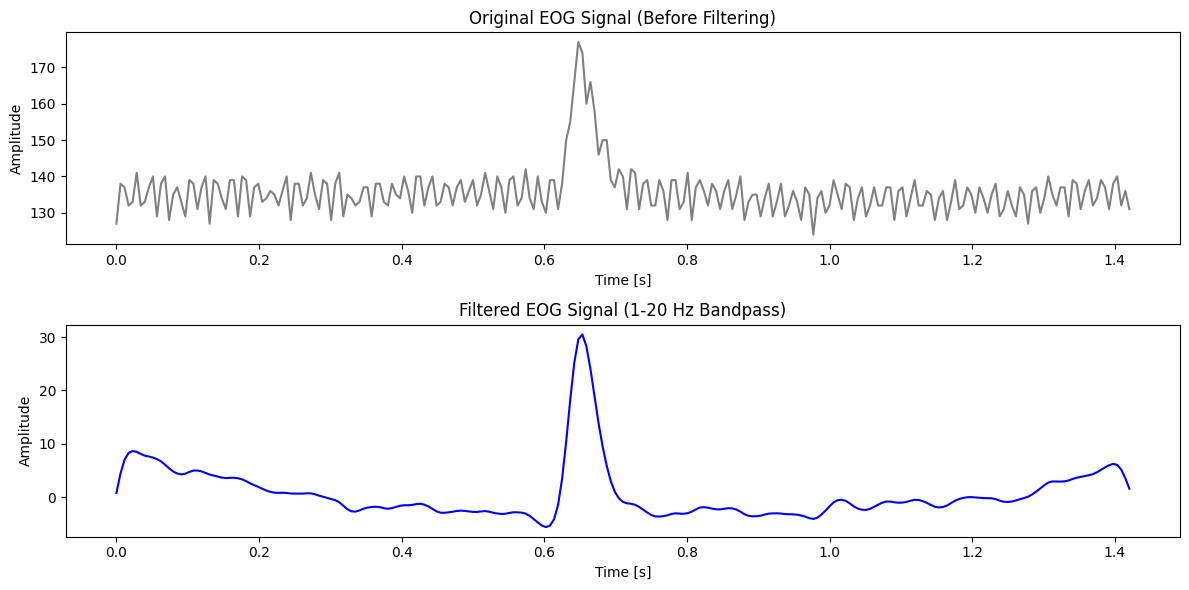

In [147]:
ploting_signal(train_h[0, :-1], train_h_filtered[0, :-1])

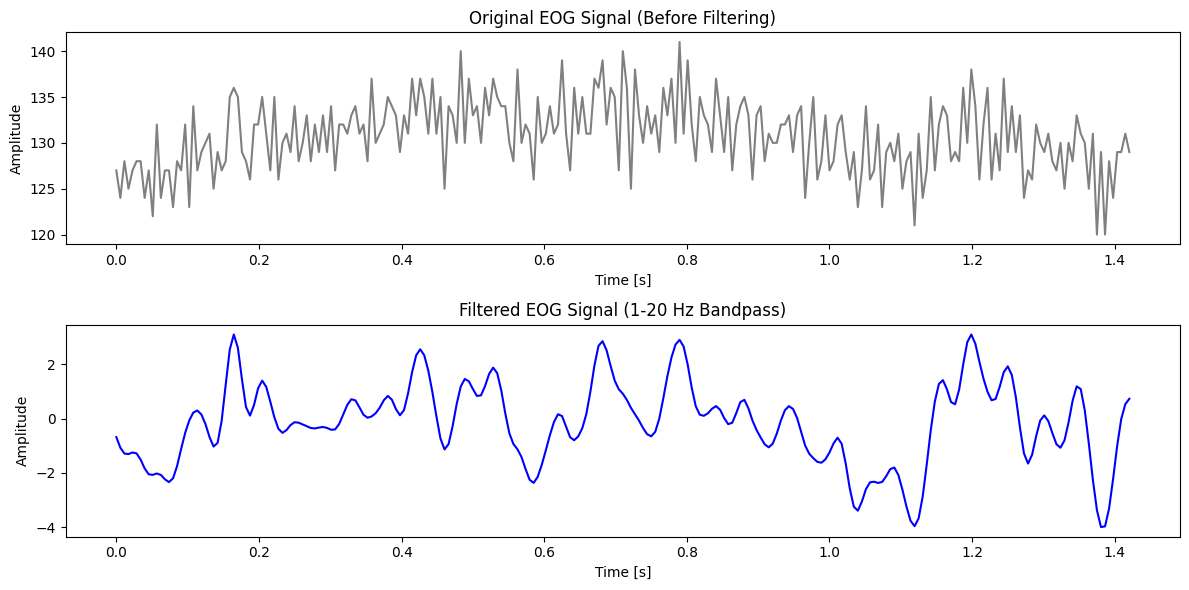

In [148]:
ploting_signal(train_v[0, :-1], train_v_filtered[0, :-1])

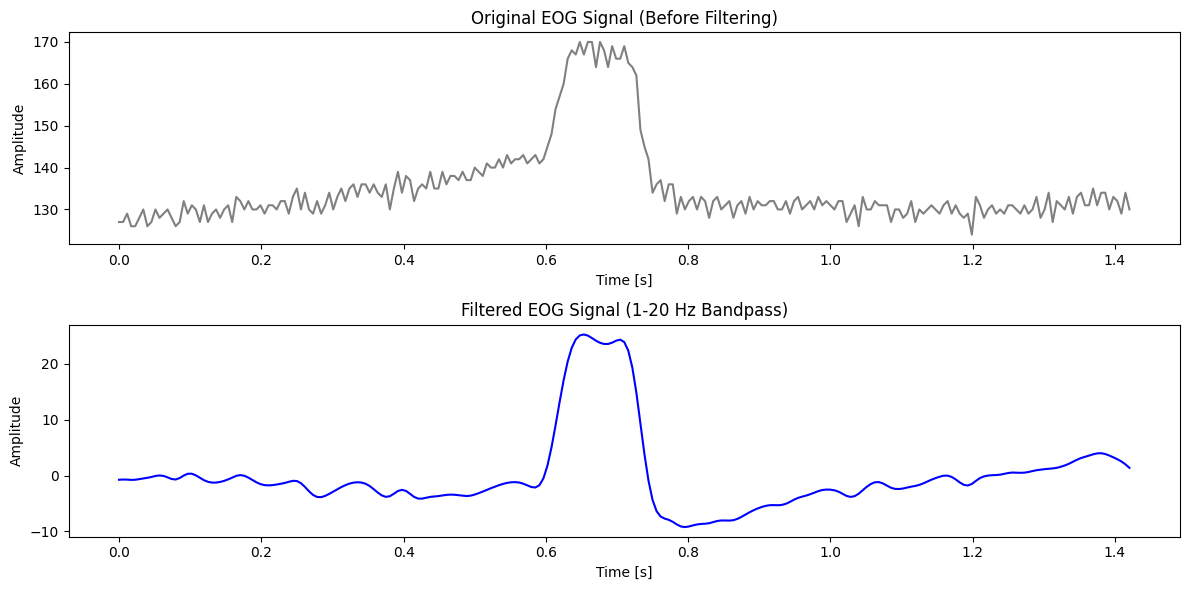

In [149]:
ploting_signal(test_h[0, :-1], test_h_filtered[0, :-1])

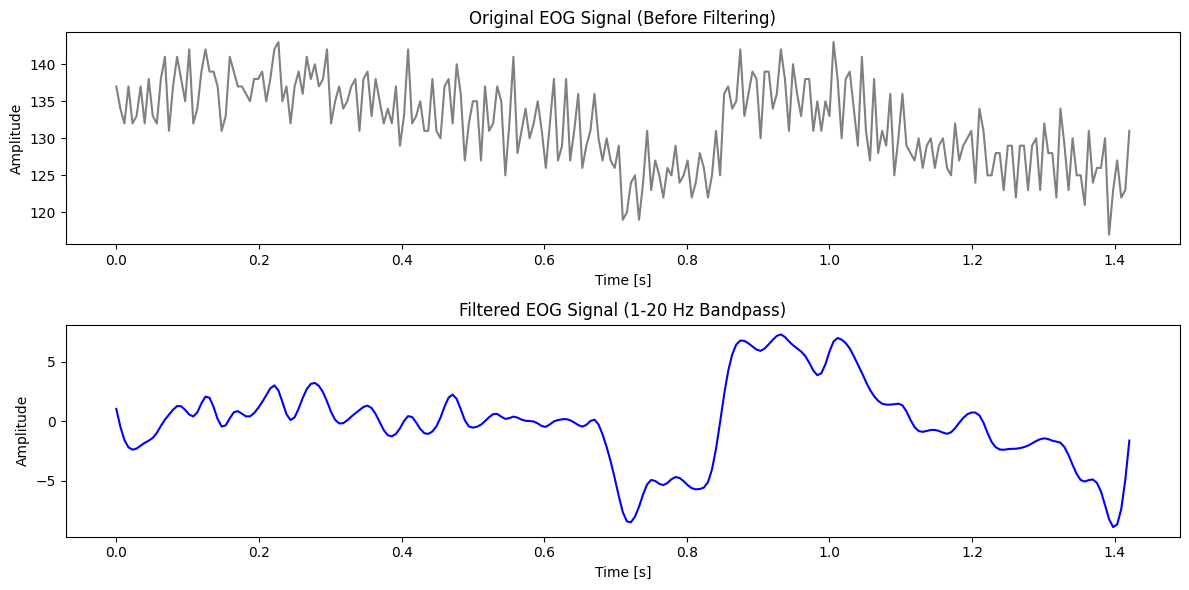

In [150]:
ploting_signal(test_v[0, :-1], test_v_filtered[0, :-1])

## ML Models

### [1] SVC

#### --- Results with DWT Features (Varying Parameters) ---

--- C: 1, Gamma: scale ---
Accuracy (SVM - DWT - Train): 0.7667
Accuracy (SVM - DWT - Test): 0.3800

--- C: 1, Gamma: 0.1 ---
Accuracy (SVM - DWT - Train): 1.0000
Accuracy (SVM - DWT - Test): 0.3400

--- C: 10, Gamma: scale ---
Accuracy (SVM - DWT - Train): 1.0000
Accuracy (SVM - DWT - Test): 0.3800

--- C: 10, Gamma: 0.1 ---
Accuracy (SVM - DWT - Train): 1.0000
Accuracy (SVM - DWT - Test): 0.3600

--- C: 50, Gamma: scale ---
Accuracy (SVM - DWT - Train): 1.0000
Accuracy (SVM - DWT - Test): 0.4400

--- C: 50, Gamma: 0.1 ---
Accuracy (SVM - DWT - Train): 1.0000
Accuracy (SVM - DWT - Test): 0.3600

--- C: 0.1, Gamma: scale ---
Accuracy (SVM - DWT - Train): 0.1867
Accuracy (SVM - DWT - Test): 0.2400

--- C: 0.1, Gamma: 0.1 ---
Accuracy (SVM - DWT - Train): 0.1867
Accuracy (SVM - DWT - Test): 0.2400

#### --- Results with DWT Features (Stronger Regularization) ---

Accuracy (SVM - DWT - Train - C=0.01): 0.4467
Accuracy (SVM - DWT - Test - C=0.01): 0.3400

#### --- Results with DWT Features (Linear Kernel) ---
Accuracy (SVM - DWT - Train - Linear): 1.0000
Accuracy (SVM - DWT - Test - Linear): 0.5000

--- Results with DWT Features (PCA) ---
Accuracy (SVM - DWT - Train - PCA): 0.8400
Accuracy (SVM - DWT - Test - PCA): 0.3600

Accuracy (SVM - DWT - Test - SMOTE): 0.4200
Fitting 5 folds for each of 40 candidates, totalling 200 fits

--- Best Parameters for SVM with DWT Features ---
Best Parameters: {'svm__C': 1, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.35333333333333333
Accuracy (Best SVM - DWT - Test): 0.4

Classification Report (Best SVM - DWT):
               precision    recall  f1-score   support

           0       0.25      0.40      0.31        10
           1       0.31      0.33      0.32        12
           2       0.56      0.50      0.53        10
           3       0.80      0.40      0.53        10
           4       0.43      0.38      0.40         8

    accuracy                           0.40        50
   macro avg       0.47      0.40      0.42        50
weighted avg       0.46      0.40      0.41        50


Confusion Matrix (Best SVM - DWT):


```
 [[4 3 0 1 2]
 [2 4 4 0 2]
 [2 3 5 0 0]
 [3 3 0 4 0]
 [5 0 0 0 3]]
```



In [258]:
svm_model = SVC(kernel='rbf', C=10, gamma=0.01, class_weight='balanced', probability=True)
svm_model.fit(X_train_dwt, y_train_dwt)

# Evaluation
y_pred = svm_model.predict(X_test_dwt)
test_accuracy = accuracy_score(y_test_dwt, y_pred)

print(f"\nAccuracy (SVM - DWT - Test ): {test_accuracy:.4f}")


Accuracy (SVM - DWT - Test ): 0.1400


#### Highest  Accuracy SVC(kernel='rbf', C=1, gamma=0.0001,
 class_weight='balanced', probability=True)


```
Accuracy (SVM - DWT - Train - C=2 - gamma=0.0001): 0.7800
Accuracy (SVM - DWT - Test - C=2 - gamma=0.0001): 0.6400
```



In [259]:
svm_dwt = SVC(kernel='rbf', C=1, gamma=0.0001, class_weight='balanced', probability=True)
svm_dwt.fit(X_train_dwt, y_train_dwt)
train_accuracy= svm_dwt.score(X_train_dwt, y_train_dwt)
test_accuracy= accuracy_score(y_test_dwt, svm_dwt.predict(X_test_dwt))
print(f"Accuracy (SVM - DWT - Train - C=2 - gamma=0.0001): {train_accuracy:.4f}")
print(f"Accuracy (SVM - DWT - Test - C=2 - gamma=0.0001): {test_accuracy:.4f}")


Accuracy (SVM - DWT - Train - C=2 - gamma=0.0001): 0.8267
Accuracy (SVM - DWT - Test - C=2 - gamma=0.0001): 0.6200


In [260]:
with open('svm_model_DWT.pkl', 'wb') as f:
    pickle.dump(svm_dwt, f)

In [156]:

# print("\n--- Results with DWT Features (Linear Kernel) ---")
# svm_pipeline_dwt_linear = Pipeline([
#     ('scaler', StandardScaler()),
#     ('svm', SVC(kernel='linear', C=10, class_weight='balanced', probability=True))
# ])
# svm_pipeline_dwt_linear.fit(X_train_dwt, y_train_dwt)
# train_accuracy_linear = svm_pipeline_dwt_linear.score(X_train_dwt, y_train_dwt)
# test_accuracy_linear = accuracy_score(y_test_dwt, svm_pipeline_dwt_linear.predict(X_test_dwt))
# print(f"Accuracy (SVM - DWT - Train - Linear): {train_accuracy_linear:.4f}")
# print(f"Accuracy (SVM - DWT - Test - Linear): {test_accuracy_linear:.4f}")


In [157]:

# # --- محاولة مع تقليل الأبعاد باستخدام PCA ---
# print("\n--- Results with DWT Features (PCA) ---")
# pca_pipeline_dwt = Pipeline([
#     ('scaler', StandardScaler()),
#     ('pca', PCA(n_components=10)),  # جرب عدد مكونات مختلف
#     ('svm', SVC(kernel='rbf', C=10, gamma='scale', class_weight='balanced', probability=True))
# ])
# pca_pipeline_dwt.fit(X_train_dwt, y_train_dwt)
# train_accuracy_pca = pca_pipeline_dwt.score(X_train_dwt, y_train_dwt)
# test_accuracy_pca = accuracy_score(y_test_dwt, pca_pipeline_dwt.predict(X_test_dwt))
# print(f"Accuracy (SVM - DWT - Train - PCA): {train_accuracy_pca:.4f}")
# print(f"Accuracy (SVM - DWT - Test - PCA): {test_accuracy_pca:.4f}")

In [158]:
# # --- مثال على استخدام SMOTE لتجميع العينات الزائد (إذا كان عدم التوازن مشكلة) ---
# smote = SMOTE(random_state=42)
# X_train_smote, y_train_smote = smote.fit_resample(X_train_dwt, y_train_dwt)
# svm_pipeline_dwt_smote = Pipeline([
#     ('scaler', StandardScaler()),
#     ('svm', SVC(kernel='rbf', C=10, gamma='scale', class_weight='balanced', probability=True))
# ])
# svm_pipeline_dwt_smote.fit(X_train_smote, y_train_smote)
# test_accuracy_smote = accuracy_score(y_test_dwt, svm_pipeline_dwt_smote.predict(X_test_dwt))
# print(f"\nAccuracy (SVM - DWT - Test - SMOTE): {test_accuracy_smote:.4f}")


In [159]:
# # --- استخدام GridSearchCV لضبط المعلمات بشكل منهجي (موصى به) ---
# param_grid_dwt = {
#     'svm__C': [0.01, 0.1, 1, 10, 100],
#     'svm__gamma': ['scale', 0.01, 0.1, 1],
#     'svm__kernel': ['rbf', 'linear']
# }

# grid_search_dwt = GridSearchCV(Pipeline([('svm', SVC(class_weight='balanced', probability=True))]),
#                                param_grid_dwt, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
# grid_search_dwt.fit(X_train_dwt, y_train_dwt)

# print("\n--- Best Parameters for SVM with DWT Features ---")
# print("Best Parameters:", grid_search_dwt.best_params_)
# print("Best Cross-Validation Accuracy:", grid_search_dwt.best_score_)

# best_svm_dwt = grid_search_dwt.best_estimator_
# test_accuracy_best_dwt = accuracy_score(y_test_dwt, best_svm_dwt.predict(X_test_dwt))
# print("Accuracy (Best SVM - DWT - Test):", test_accuracy_best_dwt)
# print("\nClassification Report (Best SVM - DWT):\n", classification_report(y_test_dwt, best_svm_dwt.predict(X_test_dwt)))
# print("\nConfusion Matrix (Best SVM - DWT):\n", confusion_matrix(y_test_dwt, best_svm_dwt.predict(X_test_dwt)))

### [2] RF

#### --- Results with Random Forest (DWT Features) ---
Accuracy (Random Forest - DWT): 0.62

Classification Report (Random Forest - DWT):
               precision    recall  f1-score   support

           0       0.50      0.50      0.50        10
           1       0.75      0.75      0.75        12
           2       0.80      0.80      0.80        10
           3       0.67      0.40      0.50        10
           4       0.42      0.62      0.50         8

    accuracy                           0.62        50
   macro avg       0.63      0.61      0.61        50
weighted avg       0.64      0.62      0.62        50


Confusion Matrix (Random Forest - DWT):


```
 [[5 1 0 1 3]
 [0 9 1 0 2]
 [1 1 8 0 0]
 [2 1 1 4 2]
 [2 0 0 1 5]]
```





Fitting 5 folds for each of 256 candidates, totalling 1280 fits

--- Best Parameters for Random Forest with DWT Features ---
Best Parameters: {'rf__max_depth': 5, 'rf__min_samples_leaf': 3, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
Best Cross-Validation Accuracy: 0.5466666666666666
Accuracy (Best Random Forest - DWT - Test): 0.6

Classification Report (Best Random Forest - DWT):
               precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.78      0.58      0.67        12
           2       0.67      0.80      0.73        10
           3       0.67      0.40      0.50        10
           4       0.38      0.62      0.48         8

    accuracy                           0.60        50
   macro avg       0.62      0.60      0.59        50
weighted avg       0.63      0.60      0.60        50


Confusion Matrix (Best Random Forest - DWT):

```
 [[6 0 0 1 3]
 [0 7 2 0 3]
 [1 1 8 0 0]
 [1 1 2 4 2]
 [2 0 0 1 5]]
```



In [185]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_dwt)
X_test_scaled= scaler.transform(X_test_dwt)


In [169]:
with open('scaler_dwt.pkl', 'wb') as f:
    pickle.dump(scaler, f)


In [205]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train_scaled, y_train_dwt)

# 3. Prediction
y_pred_rf = rf_model.predict(X_test_scaled)

# 4. Save both model and scaler
with open('random_forest_dwt_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)


# 5. Evaluation
print("Accuracy (Random Forest - DWT):", accuracy_score(y_test_dwt, y_pred_rf))
print("\nClassification Report (Random Forest - DWT):\n", classification_report(y_test_dwt, y_pred_rf))
print("\nConfusion Matrix (Random Forest - DWT):\n", confusion_matrix(y_test_dwt, y_pred_rf))

Accuracy (Random Forest - DWT): 0.7

Classification Report (Random Forest - DWT):
               precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       1.00      0.58      0.74        12
           2       0.80      0.80      0.80        10
           3       0.67      0.80      0.73        10
           4       0.50      0.62      0.56         8

    accuracy                           0.70        50
   macro avg       0.72      0.70      0.70        50
weighted avg       0.74      0.70      0.70        50


Confusion Matrix (Random Forest - DWT):
 [[7 0 0 0 3]
 [1 7 2 0 2]
 [0 0 8 2 0]
 [2 0 0 8 0]
 [1 0 0 2 5]]


### Evaluation Plots

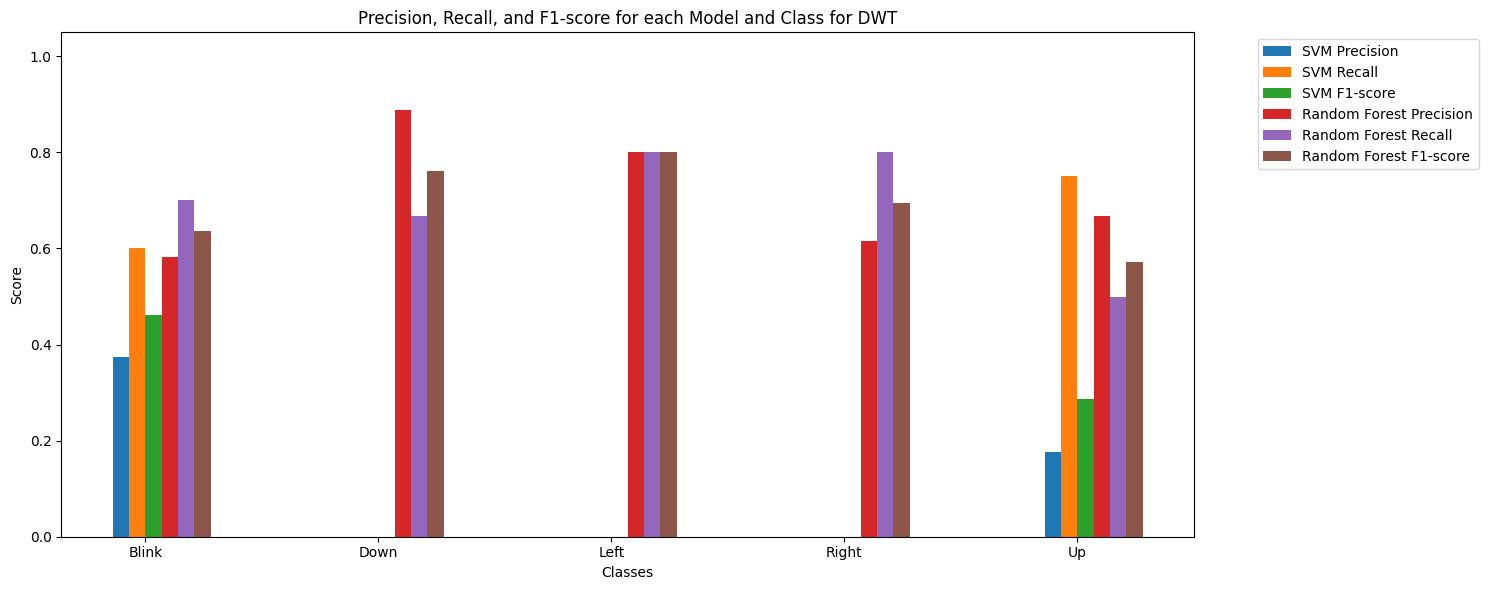

In [187]:


models = [
    ('SVM', svm_model),
    ('Random Forest', rf_model)
]

class_names = ['Blink', 'Down','Left', 'Right','Up']


plot_model_metrics(models, X_test_scaled, y_test_dwt, class_names,"DWT")


#  **[2] AR**

## Featurs

In [221]:
print(type(train_h_filtered[0]))
print(train_h_filtered[0])


<class 'numpy.ndarray'>
[ 7.78969886e-01  4.42010167e+00  7.00374750e+00  8.28407016e+00
  8.64724384e+00  8.48775773e+00  8.09985376e+00  7.78200609e+00
  7.61553081e+00  7.42725781e+00  7.12288568e+00  6.70278238e+00
  6.10213763e+00  5.39493252e+00  4.81314889e+00  4.43656938e+00
  4.26747027e+00  4.39428673e+00  4.73388512e+00  4.98368408e+00
  4.99812980e+00  4.83206981e+00  4.53834409e+00  4.23986633e+00
  4.05023413e+00  3.87611347e+00  3.66703119e+00  3.57591447e+00
  3.62528827e+00  3.63357898e+00  3.53463328e+00  3.34635595e+00
  3.01025777e+00  2.59134572e+00  2.24331416e+00  1.93079466e+00
  1.57398250e+00  1.24090499e+00  9.97590226e-01  8.44980144e-01
  8.01493863e-01  8.22534834e-01  7.84111465e-01  6.97856889e-01
  6.66730226e-01  6.64782990e-01  6.68584462e-01  7.20433574e-01
  7.16572001e-01  5.37390537e-01  2.87112786e-01  6.93080662e-02
 -1.58266867e-01 -3.67817005e-01 -5.63605693e-01 -9.57014373e-01
 -1.60956500e+00 -2.25857240e+00 -2.65464141e+00 -2.71345629e+00
 

In [222]:
best_lag_h, best_mse_h = evaluate_ar_lags(train_h_filtered, max_lag=30)
best_lag_v, best_mse_v = evaluate_ar_lags(train_v_filtered, max_lag=30)
print(f"Horiz signal: best lag = {best_lag_h} with MSE = {best_mse_h}")
print(f"Vert signal: best lag = {best_lag_v} with MSE = {best_mse_v}")


Lag: 1, MSE: 1.3143
Lag: 2, MSE: 1.2805
Lag: 3, MSE: 1.2751
Lag: 4, MSE: 1.3154
Lag: 5, MSE: 1.3481
Lag: 6, MSE: 1.4435
Lag: 7, MSE: 1.4073
Lag: 8, MSE: 1.3517
Lag: 9, MSE: 1.4462
Lag: 10, MSE: 1.4857
Lag: 11, MSE: 1.4398
Lag: 12, MSE: 1.6980
Lag: 13, MSE: 1.8158
Lag: 14, MSE: 1.5268
Lag: 15, MSE: 1.6101
Lag: 16, MSE: 1.7841
Lag: 17, MSE: 1.7770
Lag: 18, MSE: 1.6831
Lag: 19, MSE: 1.6899
Lag: 20, MSE: 2.0306
Lag: 21, MSE: 2.1390
Lag: 22, MSE: 2.8349
Lag: 23, MSE: 3.3961
Lag: 24, MSE: 3.6357
Lag: 25, MSE: 4.1725
Lag: 26, MSE: 4.9759
Lag: 27, MSE: 3.9041
Lag: 28, MSE: 6.7276
Lag: 29, MSE: 3084.0790
Error at lag 30: The model specification cannot be estimated. The model contains 31 regressors (1 trend, 0 seasonal, 30 lags) but after adjustment for hold_back and creation of the lags, there are only 30 data points available to estimate parameters.
Lag: 1, MSE: 1.0787
Lag: 2, MSE: 1.0667
Lag: 3, MSE: 1.0757
Lag: 4, MSE: 1.0813
Lag: 5, MSE: 1.0904
Lag: 6, MSE: 1.0733
Lag: 7, MSE: 1.0776
Lag: 8

In [225]:
# حدد نفس order للكل بناءً على أفضل قيمة لقيتها (مثلاً 7)
common_ar_order =5
# استخراج ميزات AR باستخدام نفس order
train_h_ar = to_feature_array(train_h_filtered, ar_order=common_ar_order)
test_h_ar = to_feature_array(test_h_filtered, ar_order=common_ar_order)
train_v_ar = to_feature_array(train_v_filtered, ar_order=common_ar_order)
test_v_ar = to_feature_array(test_v_filtered, ar_order=common_ar_order)

# دمج بيانات التدريب
X_train_ar = np.vstack((train_h_ar[:, :-1], train_v_ar[:, :-1])).astype(float)
y_train_ar = np.concatenate((train_h_ar[:, -1], train_v_ar[:, -1])).astype(int)

# دمج بيانات الاختبار
X_test_ar = np.vstack((test_h_ar[:, :-1], test_v_ar[:, :-1])).astype(float)
y_test_ar = np.concatenate((test_h_ar[:, -1], test_v_ar[:, -1])).astype(int)

# طباعة الأشكال
print(f"شكل X_train_ar: {X_train_ar.shape}")
print(f"شكل y_train_ar: {y_train_ar.shape}")
print(f"شكل X_test_ar: {X_test_ar.shape}")
print(f"شكل y_test_ar: {y_test_ar.shape}")


شكل X_train_ar: (150, 6)
شكل y_train_ar: (150,)
شكل X_test_ar: (50, 6)
شكل y_test_ar: (50,)


#### Using Class Weight for imbalanced problem

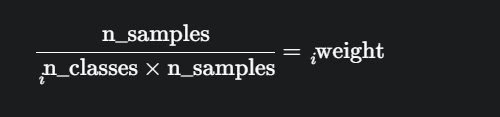

## ML Models

### [1]SVC


####--- Results with AR Features (Varying Parameters) ---

--- C: 1, Gamma: scale ---
Accuracy (SVM - AR - Train): 0.5067
Accuracy (SVM - AR - Test): 0.5200

--- C: 1, Gamma: 0.1 ---
Accuracy (SVM - AR - Train): 0.5133
Accuracy (SVM - AR - Test): 0.5400

--- C: 10, Gamma: scale ---
Accuracy (SVM - AR - Train): 0.7133
Accuracy (SVM - AR - Test): 0.7000

--- C: 10, Gamma: 0.1 ---
Accuracy (SVM - AR - Train): 0.7200
Accuracy (SVM - AR - Test): 0.7000

--- C: 50, Gamma: scale ---
Accuracy (SVM - AR - Train): 0.8333
Accuracy (SVM - AR - Test): 0.6400

--- C: 50, Gamma: 0.1 ---
Accuracy (SVM - AR - Train): 0.8533
Accuracy (SVM - AR - Test): 0.6600

--- C: 0.1, Gamma: scale ---
Accuracy (SVM - AR - Train): 0.3733
Accuracy (SVM - AR - Test): 0.3800

--- C: 0.1, Gamma: 0.1 ---
Accuracy (SVM - AR - Train): 0.3667
Accuracy (SVM - AR - Test): 0.4200

In [244]:
# X_train_scaled = scaler.fit_transform(X_train_ar)
# X_test_scaled= scaler.transform(X_test_ar)


In [247]:
print("\n--- Results with AR Features (Varying Parameters) ---")

param_ranges = [
    {'C': 1, 'gamma': 'scale'},
    {'C': 1, 'gamma': 0.1},
    {'C': 10, 'gamma': 'scale'},
    {'C': 10, 'gamma': 0.1},
    {'C': 50, 'gamma': 'scale'},
    {'C': 50, 'gamma': 0.1},
    {'C': 0.1, 'gamma': 'scale'},
    {'C': 0.1, 'gamma': 0.1},
]

for params in param_ranges:
    C_val = params['C']
    gamma_val = params['gamma']

    svm_ar =SVC(kernel='rbf', C=C_val, gamma=gamma_val, class_weight='balanced', probability=True)
    svm_ar.fit(X_train_ar, y_train_ar)

    train_accuracy = svm_ar.score(X_train_ar, y_train_ar)
    test_accuracy = accuracy_score(y_test_ar, svm_ar.predict(X_test_ar))

    print(f"\n--- C: {C_val}, Gamma: {gamma_val} ---")
    print(f"Accuracy (SVM - AR - Train): {train_accuracy:.4f}")
    print(f"Accuracy (SVM - AR - Test): {test_accuracy:.4f}")


--- Results with AR Features (Varying Parameters) ---

--- C: 1, Gamma: scale ---
Accuracy (SVM - AR - Train): 0.3067
Accuracy (SVM - AR - Test): 0.2800

--- C: 1, Gamma: 0.1 ---
Accuracy (SVM - AR - Train): 0.4133
Accuracy (SVM - AR - Test): 0.4200

--- C: 10, Gamma: scale ---
Accuracy (SVM - AR - Train): 0.3667
Accuracy (SVM - AR - Test): 0.4400

--- C: 10, Gamma: 0.1 ---
Accuracy (SVM - AR - Train): 0.4467
Accuracy (SVM - AR - Test): 0.5600

--- C: 50, Gamma: scale ---
Accuracy (SVM - AR - Train): 0.4067
Accuracy (SVM - AR - Test): 0.4400

--- C: 50, Gamma: 0.1 ---
Accuracy (SVM - AR - Train): 0.5467
Accuracy (SVM - AR - Test): 0.6200

--- C: 0.1, Gamma: scale ---
Accuracy (SVM - AR - Train): 0.1867
Accuracy (SVM - AR - Test): 0.2400

--- C: 0.1, Gamma: 0.1 ---
Accuracy (SVM - AR - Train): 0.2533
Accuracy (SVM - AR - Test): 0.3800


In [264]:
svm_ar= SVC(kernel='rbf', C=50, gamma=0.1, class_weight='balanced', probability=True)

svm_ar.fit(X_train_ar, y_train_ar)
train_accuracy = svm_ar.score(X_train_ar, y_train_ar)
test_accuracy = accuracy_score(y_test_ar, svm_ar.predict(X_test_ar))
print(f"Accuracy (SVM - AR - Train): {train_accuracy:.4f}")
print(f"Accuracy (SVM - AR - Test): {test_accuracy:.4f}")

Accuracy (SVM - AR - Train): 0.5467
Accuracy (SVM - AR - Test): 0.6200


In [240]:


# Suppose `model` is your trained model (e.g., SVM, RandomForest, etc.)
with open('svm_ar.pkl', 'wb') as file:
    pickle.dump(svm_ar, file)

### [2] RF

#### RF -> Overfitting Problem -> Defult parameters


1.   Accuracy (Random Forest - AR - Train): 1.0

2.   Accuracy (Random Forest - AR - Test): 0.48



#### --- Results with Random Forest (AR Features - Tuned) ---
1.   Accuracy (Random Forest - AR - Train - Tuned): 0.8466666666666667
2.   Accuracy (Random Forest - AR - Test - Tuned): 0.56

* random_state=42,
* n_estimators=50,       # تقليل عدد الأشجار
* max_depth=5,           # تقليل أقصى عمق
* min_samples_split=5,   # زيادة الحد الأدنى لتقسيم العقدة
* min_samples_leaf=3






#### --- Results with Random Forest (AR Features - Tuned) ---
1. Accuracy (Random Forest - AR - Train - Tuned): 0.8333333333333334
2. Accuracy (Random Forest - AR - Test - Tuned): 0.58

* random_state=42,
* n_estimators=85,       # تقليل عدد الأشجار
* max_depth=5,           # تقليل أقصى عمق
* min_samples_split=4,   # زيادة الحد الأدنى لتقسيم العقدة
* min_samples_leaf=3

In [249]:
param_grid = [
    {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 2},
    {'n_estimators': 150, 'max_depth': 20, 'min_samples_split': 18, 'min_samples_leaf': 3},
    {'n_estimators': 200, 'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 1},
    {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1},
    {'n_estimators': 120, 'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 4},
]

for params in param_grid:
    rf = RandomForestClassifier(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        min_samples_split=params['min_samples_split'],
        min_samples_leaf=params['min_samples_leaf'],
        random_state=42
    )
    rf.fit(X_train_ar, y_train_ar)
    y_pred_train = rf.predict(X_train_ar)
    y_pred_test = rf.predict(X_test_ar)

    print(f"\n--- Params: {params} ---")
    print(f"Train Accuracy: {accuracy_score(y_train_ar, y_pred_train):.4f}")
    print(f"Test Accuracy: {accuracy_score(y_test_ar, y_pred_test):.4f}")
    print("Classification Report:\n", classification_report(y_test_ar, y_pred_test))
    print("Confusion Matrix:\n", confusion_matrix(y_test_ar, y_pred_test))


--- Params: {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 2} ---
Train Accuracy: 0.8400
Test Accuracy: 0.5800
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.90      0.72        10
           1       0.86      0.50      0.63        12
           2       0.62      0.50      0.56        10
           3       0.45      0.50      0.48        10
           4       0.44      0.50      0.47         8

    accuracy                           0.58        50
   macro avg       0.60      0.58      0.57        50
weighted avg       0.61      0.58      0.58        50

Confusion Matrix:
 [[9 0 0 1 0]
 [4 6 0 1 1]
 [0 0 5 2 3]
 [2 0 2 5 1]
 [0 1 1 2 4]]

--- Params: {'n_estimators': 150, 'max_depth': 20, 'min_samples_split': 18, 'min_samples_leaf': 3} ---
Train Accuracy: 0.7400
Test Accuracy: 0.5400
Classification Report:
               precision    recall  f1-score   support

           0       0.53  

In [233]:
rf = RandomForestClassifier(
        n_estimators=120,
        max_depth=5,
        min_samples_split=20,
        min_samples_leaf=1
    )
rf.fit(X_train_ar, y_train_ar)
y_pred_train = rf.predict(X_train_ar)
y_pred_test = rf.predict(X_test_ar)

print(f"\n--- Params: {params} ---")
print(f"Train Accuracy: {accuracy_score(y_train_ar, y_pred_train):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test_ar, y_pred_test):.4f}")
print("Classification Report:\n", classification_report(y_test_ar, y_pred_test))
print("Confusion Matrix:\n", confusion_matrix(y_test_ar, y_pred_test))


--- Params: {'n_estimators': 120, 'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 4} ---
Train Accuracy: 0.7067
Test Accuracy: 0.5200
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.90      0.67        10
           1       0.75      0.50      0.60        12
           2       0.71      0.50      0.59        10
           3       0.40      0.40      0.40        10
           4       0.25      0.25      0.25         8

    accuracy                           0.52        50
   macro avg       0.53      0.51      0.50        50
weighted avg       0.55      0.52      0.51        50

Confusion Matrix:
 [[9 0 0 1 0]
 [5 6 0 1 0]
 [0 0 5 2 3]
 [2 0 1 4 3]
 [1 2 1 2 2]]


### Evaluation Plot

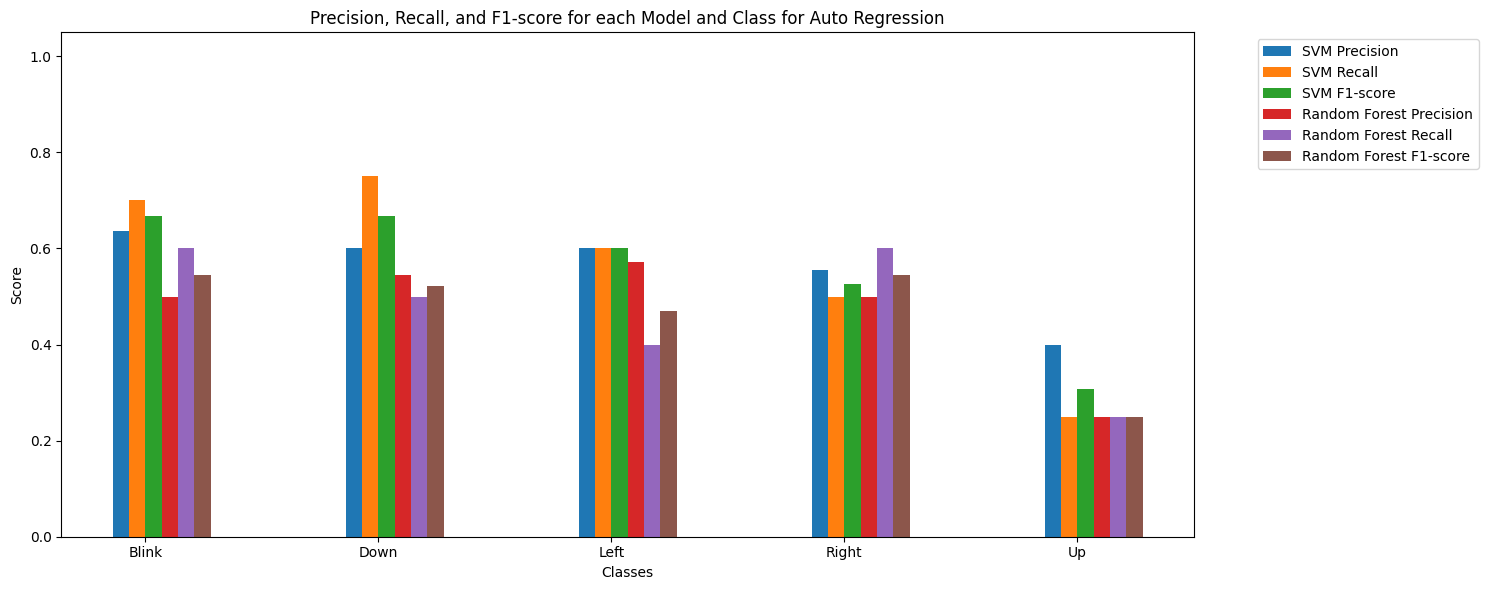

In [196]:
models = [
    ('SVM', svm_ar),
    ('Random Forest', rf)
]

class_names = ['Blink', 'Down','Left', 'Right','Up']


plot_model_metrics(models, X_test_ar, y_test_ar, class_names,"Auto Regression")

# **[3] Hjorth Parameters**

In [282]:
# --- استخدام الدالة على مجموعات البيانات ---
train_h_hjorth = extract_hjorth_features(train_h_filtered)
test_h_hjorth = extract_hjorth_features(test_h_filtered)
train_v_hjorth = extract_hjorth_features(train_v_filtered)
test_v_hjorth = extract_hjorth_features(test_v_filtered)

# --- دمج بيانات التدريب والاختبار ---
X_train_hjorth = np.vstack((train_h_hjorth[:, :-1], train_v_hjorth[:, :-1])).astype(float)
y_train_hjorth = np.concatenate((train_h_hjorth[:, -1], train_v_hjorth[:, -1])).astype(int)

X_test_hjorth = np.vstack((test_h_hjorth[:, :-1], test_v_hjorth[:, :-1])).astype(float)
y_test_hjorth = np.concatenate((test_h_hjorth[:, -1], test_v_hjorth[:, -1])).astype(int)



In [283]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_hjorth)
X_test_scaled = scaler.transform(X_test_hjorth )

In [284]:
# --- تدريب نموذج SVM ---
svm_clf = SVC(kernel='rbf', C=10, gamma=0.1, class_weight='balanced', probability=True, random_state=42)
svm_clf.fit(X_train_scaled, y_train_hjorth)

# --- التقييم ---
y_pred = svm_clf.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test_hjorth, y_pred))
print("\nClassification Report:\n", classification_report(y_test_hjorth, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_hjorth, y_pred))

Accuracy: 0.68

Classification Report:
               precision    recall  f1-score   support

           0       0.77      1.00      0.87        17
           1       0.47      0.88      0.61         8
           2       0.78      1.00      0.88         7
           3       1.00      0.14      0.25         7
           4       0.67      0.18      0.29        11

    accuracy                           0.68        50
   macro avg       0.74      0.64      0.58        50
weighted avg       0.73      0.68      0.61        50


Confusion Matrix:
 [[17  0  0  0  0]
 [ 1  7  0  0  0]
 [ 0  0  7  0  0]
 [ 1  3  1  1  1]
 [ 3  5  1  0  2]]


In [285]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
rf=RandomForestClassifier(random_state=42)
lr=LogisticRegression(max_iter=1000, random_state=42)
knn=KNeighborsClassifier(n_neighbors=5)
models = {
    "Random Forest": rf,
    "Logistic Regression": lr,
    "K-Nearest Neighbors": knn
}

# تدريب وتقييم كل موديل
for name, model in models.items():
    model.fit(X_train_scaled, y_train_hjorth)
    y_pred = model.predict(X_test_scaled)
    print(f"--- {name} ---")
    print(f"Accuracy: {accuracy_score(y_test_hjorth, y_pred):.4f}")
    print(classification_report(y_test_hjorth, y_pred))
    print("-" * 40)

--- Random Forest ---
Accuracy: 0.7000
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        17
           1       0.67      0.75      0.71         8
           2       0.71      0.71      0.71         7
           3       0.50      0.43      0.46         7
           4       0.80      0.36      0.50        11

    accuracy                           0.70        50
   macro avg       0.68      0.65      0.65        50
weighted avg       0.70      0.70      0.68        50

----------------------------------------
--- Logistic Regression ---
Accuracy: 0.6400
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        17
           1       0.62      0.62      0.62         8
           2       0.56      0.71      0.62         7
           3       0.50      0.29      0.36         7
           4       0.43      0.27      0.33        11

    accuracy                           0.64        50
   mac

### Models Evaluation

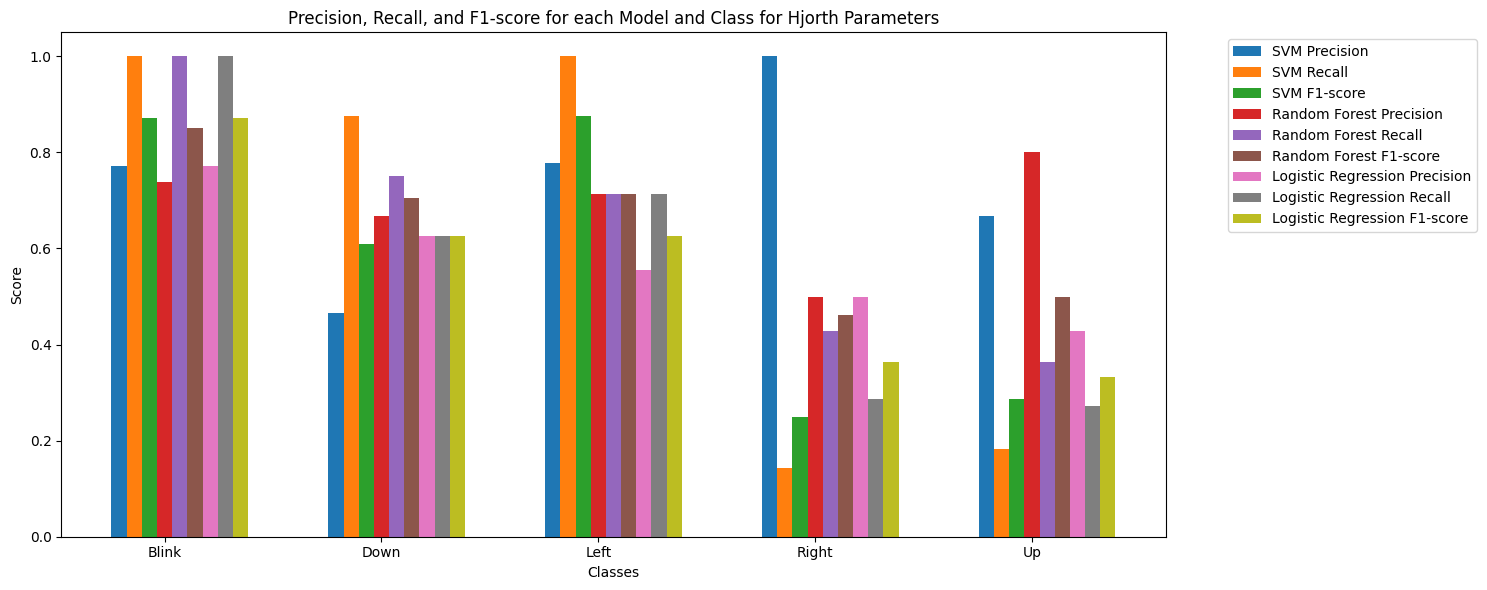

In [286]:
models = [
    ('SVM', svm_clf),
    ("Random Forest" , rf),
    ("Logistic Regression", lr)
    # ("K-Nearest Neighbors", knn)
]

class_names = ['Blink', 'Down','Left', 'Right','Up']


plot_model_metrics(models, X_test_scaled, y_test_hjorth, class_names,"Hjorth Parameters")

# **[4] Wavelet Packet Decomposition (WPD)**

In [269]:
# تطبيق الدالة على مجموعات البيانات (train_h_filtered, test_h_filtered, train_v_filtered, test_v_filtered)
train_h_wpd = extract_wpd_features_with_labels(train_h_filtered)
test_h_wpd = extract_wpd_features_with_labels(test_h_filtered)
train_v_wpd = extract_wpd_features_with_labels(train_v_filtered)
test_v_wpd = extract_wpd_features_with_labels(test_v_filtered)

# دمج بيانات التدريب والاختبار
X_train_wpd = np.vstack((train_h_wpd[:, :-1], train_v_wpd[:, :-1])).astype(float)
y_train_wpd = np.concatenate((train_h_wpd[:, -1], train_v_wpd[:, -1])).astype(int)

X_test_wpd = np.vstack((test_h_wpd[:, :-1], test_v_wpd[:, :-1])).astype(float)
y_test_wpd = np.concatenate((test_h_wpd[:, -1], test_v_wpd[:, -1])).astype(int)


In [270]:
X_train_scaled = scaler.fit_transform(X_train_wpd)
X_test_scaled = scaler.transform(X_test_wpd)

In [271]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

rf=RandomForestClassifier(random_state=42)
lg=LogisticRegression(max_iter=1000, random_state=42)
svc= SVC(kernel='rbf', C=10, gamma='scale', class_weight='balanced', probability=True, random_state=42)
knn=KNeighborsClassifier(n_neighbors=5)
dt=DecisionTreeClassifier(random_state=42)
gb=GradientBoostingClassifier(random_state=42)
models = {
    "Random Forest": rf,
    "Logistic Regression": lg,
    "SVM (RBF Kernel)": svc,
    "K-Nearest Neighbors": knn,
    "Decision Tree": dt,
    "Gradient Boosting":gb
}



for name, model in models.items():
    model.fit(X_train_scaled, y_train_wpd)
    y_pred = model.predict(X_test_scaled)
    print(f"--- {name} ---")
    print(f"Accuracy: {accuracy_score(y_test_wpd, y_pred):.4f}")
    print("-" * 40)


--- Random Forest ---
Accuracy: 0.6000
----------------------------------------
--- Logistic Regression ---
Accuracy: 0.3600
----------------------------------------
--- SVM (RBF Kernel) ---
Accuracy: 0.5600
----------------------------------------
--- K-Nearest Neighbors ---
Accuracy: 0.5600
----------------------------------------
--- Decision Tree ---
Accuracy: 0.4400
----------------------------------------
--- Gradient Boosting ---
Accuracy: 0.5400
----------------------------------------


### evaluation model

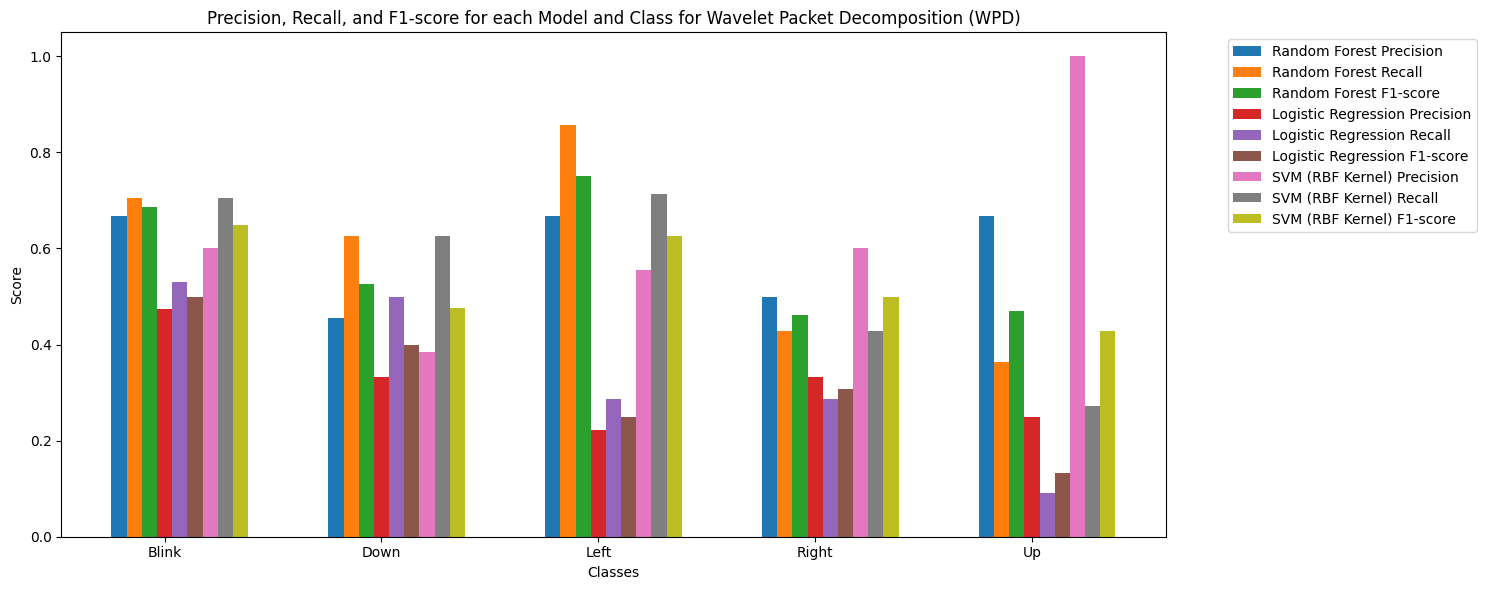

In [272]:
models = [
    ("Random Forest", rf),
   ( "Logistic Regression",lg),
    ("SVM (RBF Kernel)", svc)
  #  ( "K-Nearest Neighbors", knn),
  #  ( "Decision Tree", dt),
  #  ( "Gradient Boosting",gb)
]

class_names = ['Blink', 'Down','Left', 'Right','Up']


plot_model_metrics(models, X_test_scaled, y_test_wpd, class_names,"Wavelet Packet Decomposition (WPD)")

# **[5] EMD (Empirical Mode Decomposition)**

In [273]:
# تطبيق على بيانات التدريب والاختبار (مثال)
train_h_emd = extract_emd_features_with_labels(train_h_filtered)
test_h_emd = extract_emd_features_with_labels(test_h_filtered)
train_v_emd = extract_emd_features_with_labels(train_v_filtered)
test_v_emd = extract_emd_features_with_labels(test_v_filtered)

X_train_emd = np.vstack((train_h_emd[:, :-1], train_v_emd[:, :-1])).astype(float)
y_train_emd = np.concatenate((train_h_emd[:, -1], train_v_emd[:, -1])).astype(int)

X_test_emd = np.vstack((test_h_emd[:, :-1], test_v_emd[:, :-1])).astype(float)
y_test_emd = np.concatenate((test_h_emd[:, -1], test_v_emd[:, -1])).astype(int)

In [274]:
X_train_scaled = scaler.fit_transform(X_train_emd)
X_test_scaled = scaler.transform(X_test_emd)


In [275]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
# هنعرف دالة صغيرة للتدريب والاختبار والطباعة
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy ({model.__class__.__name__}): {acc:.4f}")
    return acc

svm_clf=  SVC(kernel='rbf', C=1, gamma=0.1, class_weight='balanced', probability=True)
rf=RandomForestClassifier(n_estimators=150,max_depth=7, random_state=42)
knn=   KNeighborsClassifier(n_neighbors=5)
# موديولات مختلفة
models = [
   svm_clf,rf,
    LogisticRegression(max_iter=5000, class_weight='balanced', random_state=42),
    knn,
    DecisionTreeClassifier(random_state=42)
]

for mdl in models:
    train_and_evaluate_model(mdl, X_train_scaled, y_train_emd, X_test_scaled, y_test_emd)

Accuracy (SVC): 0.4600
Accuracy (RandomForestClassifier): 0.4400
Accuracy (LogisticRegression): 0.5400
Accuracy (KNeighborsClassifier): 0.5600
Accuracy (DecisionTreeClassifier): 0.3400


### Evaluation models

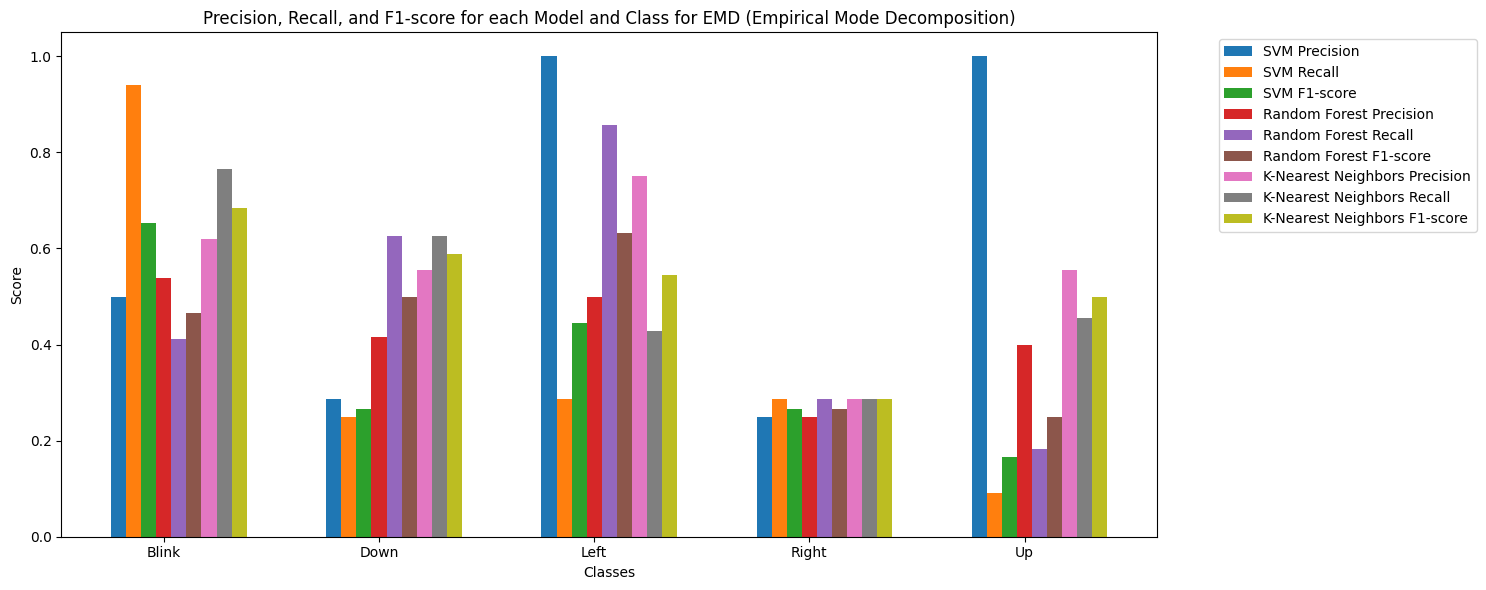

In [276]:
models = [
    ('SVM', svm_clf),
    ("Random Forest" , rf),
    # ("Logistic Regression", lr)
    ("K-Nearest Neighbors", knn)
]

class_names = ['Blink', 'Down','Left', 'Right','Up']


plot_model_metrics(models, X_test_scaled, y_test_emd, class_names,"EMD (Empirical Mode Decomposition)")

# **[6] TSFEL or tsfresh (Auto Feature Extraction)**

## Features

In [288]:
# --- خطوة 2: استخراج الميزات مع إضافة الليبل ---
train_h_tsfel = np.array([
    np.append(extract_tsfel_features_from_signal(sig), label)
    for sig, label in zip(train_h_filtered[:, :-1], train_h_filtered[:, -1])
])

test_h_tsfel = np.array([
    np.append(extract_tsfel_features_from_signal(sig), label)
    for sig, label in zip(test_h_filtered[:, :-1], test_h_filtered[:, -1])
])

train_v_tsfel = np.array([
    np.append(extract_tsfel_features_from_signal(sig), label)
    for sig, label in zip(train_v_filtered[:, :-1], train_v_filtered[:, -1])
])

test_v_tsfel = np.array([
    np.append(extract_tsfel_features_from_signal(sig), label)
    for sig, label in zip(test_v_filtered[:, :-1], test_v_filtered[:, -1])
])

# --- خطوة 3: دمج بيانات التدريب والاختبار ---
X_train_tsfel = np.vstack((train_h_tsfel[:, :-1], train_v_tsfel[:, :-1])).astype(float)
y_train_tsfel = np.concatenate((train_h_tsfel[:, -1], train_v_tsfel[:, -1])).astype(int)

X_test_tsfel = np.vstack((test_h_tsfel[:, :-1], test_v_tsfel[:, :-1])).astype(float)
y_test_tsfel = np.concatenate((test_h_tsfel[:, -1], test_v_tsfel[:, -1])).astype(int)


<ipython-input-140-1b988bcf0319>:7: UserWarning: Using default sampling frequency set in configuration file.
  features_df = tsfel.time_series_features_extractor(cfg, signal_df, verbose=0)
<ipython-input-140-1b988bcf0319>:7: UserWarning: Using default sampling frequency set in configuration file.
  features_df = tsfel.time_series_features_extractor(cfg, signal_df, verbose=0)
<ipython-input-140-1b988bcf0319>:7: UserWarning: Using default sampling frequency set in configuration file.
  features_df = tsfel.time_series_features_extractor(cfg, signal_df, verbose=0)
<ipython-input-140-1b988bcf0319>:7: UserWarning: Using default sampling frequency set in configuration file.
  features_df = tsfel.time_series_features_extractor(cfg, signal_df, verbose=0)
<ipython-input-140-1b988bcf0319>:7: UserWarning: Using default sampling frequency set in configuration file.
  features_df = tsfel.time_series_features_extractor(cfg, signal_df, verbose=0)
<ipython-input-140-1b988bcf0319>:7: UserWarning: Using 

## ML

### Scaling

In [289]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_tsfel)
X_test_scaled = scaler.transform(X_test_tsfel)

### [1]SVC

In [292]:
# --- تدريب نموذج SVM ---
svm_clf = SVC(kernel='rbf', C=10, gamma='scale', class_weight='balanced', probability=True, random_state=42)
svm_clf.fit(X_train_scaled, y_train_tsfel)

with open('svc_tsfel_model.pkl', 'wb') as f:
    pickle.dump(svm_clf, f)

# --- التقييم ---
y_pred = svm_clf.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test_tsfel, y_pred))
print("\nClassification Report:\n", classification_report(y_test_tsfel, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_tsfel, y_pred))

Accuracy: 0.86

Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94        17
           1       0.86      0.75      0.80         8
           2       0.78      1.00      0.88         7
           3       0.83      0.71      0.77         7
           4       0.89      0.73      0.80        11

    accuracy                           0.86        50
   macro avg       0.85      0.84      0.84        50
weighted avg       0.86      0.86      0.86        50


Confusion Matrix:
 [[17  0  0  0  0]
 [ 0  6  1  0  1]
 [ 0  0  7  0  0]
 [ 0  1  1  5  0]
 [ 2  0  0  1  8]]


### [2]RF

In [281]:

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_scaled, y_train_tsfel)  #  نستخدم نفس y بتاعتهم هوما الاتنين زي بعض سواء ترين اوتست y_train الخاص بـ DWT لأنه نفس التصنيفات
y_pred = clf.predict(X_test_scaled)

print("Accuracy (TSFEL + Random Forest):", accuracy_score(y_test_tsfel, y_pred))

Accuracy (TSFEL + Random Forest): 0.8


# **UI**

In [298]:
!pip install streamlit

In [299]:
!pip install streamlit_option_menu

In [300]:
!pip install streamlit -q

In [301]:
!wget -q -O - https://loca.lt/mytunnelpassword

34.125.171.210

In [ ]:
! streamlit run streamlit.py & npx localtunnel --port 8501